In [32]:
#Import library

from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt


In [33]:
#Buat direktori
import os

base_dir = 'C:/Users/akip/Desktop/fix-vgg16/dataset'
# Membuat direktori
os.makedirs(base_dir, exist_ok=True)

# Menampilkan isi dari direktori
print(os.listdir(base_dir))

['data', 'test', 'train', 'validasi']


In [34]:
#menentukan direktorinya
# data_dir = os.path.join(base_dir, 'data')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validasi')

In [35]:
#Direktori isi latih
train_CVPD = os.path.join(train_dir, 'CVPD/')
train_KANKER = os.path.join(train_dir, 'KANKER/')
train_ULATPELIANG = os.path.join(train_dir, 'ULATPELIANG/')
train_SEHAT = os.path.join(train_dir, 'SEHAT/')

#Direktori isi uji
validation_CVPD = os.path.join(validation_dir, 'CVPD/')
validation_KANKER = os.path.join(validation_dir, 'KANKER/')
validation_ULATPELIANG = os.path.join(validation_dir, 'ULATPELIANG/')
validation_SEHAT = os.path.join(validation_dir, 'SEHAT/')

In [36]:
print("Jumlah Train CVPD                    = ", len(os.listdir(train_CVPD)))
print("Jumlah Train kankerjeruk             = ", len(os.listdir(train_KANKER)))
print("Jumlah Train ulatpeliang             = ", len(os.listdir(train_ULATPELIANG)))
print("Jumlah Train sehat                   = ", len(os.listdir(train_SEHAT)))

print('=======================================================================================')

print("Jumlah Validation CVPD               = ", len(os.listdir(validation_CVPD)))
print("Jumlah Validation kankerjeruk        = ", len(os.listdir(validation_KANKER)))
print("Jumlah Validation ulatpeliang        = ", len(os.listdir(validation_ULATPELIANG)))
print("Jumlah Validation ulatpeliang        = ", len(os.listdir(validation_SEHAT)))


Jumlah Train CVPD                    =  800
Jumlah Train kankerjeruk             =  800
Jumlah Train ulatpeliang             =  800
Jumlah Train sehat                   =  800
Jumlah Validation CVPD               =  100
Jumlah Validation kankerjeruk        =  100
Jumlah Validation ulatpeliang        =  100
Jumlah Validation ulatpeliang        =  100


In [37]:
#Download pre-trained model VGG16
vgg = VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=max,
    classes=1000,
    classifier_activation="softmax",
)
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [38]:
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_3')>

In [39]:
#Buat parameter sebelumnya tidak dilatih lagi
for layer in vgg.layers:
  layer.trainable = False
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

# Mengambil output dari layer sebelum layer prediksi 1000
x = vgg.layers[-2].output

# Membuat layer prediksi baru dengan 4 unit dan nama 'prediction'
predictions = Dense(4, activation='softmax', name='prediksi')(x)

# Membuat model baru
model = Model(inputs=vgg.input, outputs=predictions)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [41]:
from keras import optimizers
import tensorflow as tf


adam = optimizers.Adam()
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# Definisikan metrik F1
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

# Inisialisasi optimizer
adam = optimizers.Adam()

# Kompilasi model
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  F1Score(name='f1_score')
              ])



In [42]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [43]:
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [44]:
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 3200 images belonging to 4 classes.


In [45]:
val_set = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 400 images belonging to 4 classes.


In [46]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='VGG19Epoch100.h4',
                             verbose=2, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=100,
    steps_per_epoch=len(train_set),
    validation_steps=len(val_set),
    callbacks=callbacks,
    verbose=2)  

duration = datetime.now() - start
print("Waktu Latih : ", duration)


Epoch 1/100

Epoch 1: val_loss improved from inf to 0.44104, saving model to VGG19Epoch100.h4
INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


100/100 - 247s - loss: 0.4896 - accuracy: 0.4916 - precision: 0.5757 - recall: 0.3459 - f1_score: 0.4322 - val_loss: 0.4410 - val_accuracy: 0.5500 - val_precision: 0.6238 - val_recall: 0.4725 - val_f1_score: 0.5377 - 247s/epoch - 2s/step
Epoch 2/100

Epoch 2: val_loss improved from 0.44104 to 0.40404, saving model to VGG19Epoch100.h4
INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


100/100 - 229s - loss: 0.4314 - accuracy: 0.5822 - precision: 0.6424 - recall: 0.4891 - f1_score: 0.5554 - val_loss: 0.4040 - val_accuracy: 0.6450 - val_precision: 0.7043 - val_recall: 0.5300 - val_f1_score: 0.6049 - 229s/epoch - 2s/step
Epoch 3/100

Epoch 3: val_loss improved from 0.40404 to 0.39504, saving model to VGG19Epoch100.h4
INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


100/100 - 228s - loss: 0.4129 - accuracy: 0.6019 - precision: 0.6525 - recall: 0.5141 - f1_score: 0.5751 - val_loss: 0.3950 - val_accuracy: 0.6400 - val_precision: 0.6959 - val_recall: 0.5550 - val_f1_score: 0.6175 - 228s/epoch - 2s/step
Epoch 4/100

Epoch 4: val_loss improved from 0.39504 to 0.39200, saving model to VGG19Epoch100.h4
INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


100/100 - 229s - loss: 0.3986 - accuracy: 0.6178 - precision: 0.6805 - recall: 0.5444 - f1_score: 0.6049 - val_loss: 0.3920 - val_accuracy: 0.6325 - val_precision: 0.6916 - val_recall: 0.5550 - val_f1_score: 0.6158 - 229s/epoch - 2s/step
Epoch 5/100

Epoch 5: val_loss improved from 0.39200 to 0.38328, saving model to VGG19Epoch100.h4
INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


100/100 - 226s - loss: 0.4078 - accuracy: 0.6100 - precision: 0.6534 - recall: 0.5344 - f1_score: 0.5879 - val_loss: 0.3833 - val_accuracy: 0.6575 - val_precision: 0.6964 - val_recall: 0.5850 - val_f1_score: 0.6359 - 226s/epoch - 2s/step
Epoch 6/100

Epoch 6: val_loss did not improve from 0.38328
100/100 - 222s - loss: 0.3923 - accuracy: 0.6309 - precision: 0.6825 - recall: 0.5669 - f1_score: 0.6193 - val_loss: 0.3947 - val_accuracy: 0.6300 - val_precision: 0.6696 - val_recall: 0.5675 - val_f1_score: 0.6143 - 222s/epoch - 2s/step
Epoch 7/100

Epoch 7: val_loss improved from 0.38328 to 0.38032, saving model to VGG19Epoch100.h4
INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


100/100 - 227s - loss: 0.3883 - accuracy: 0.6406 - precision: 0.6797 - recall: 0.5722 - f1_score: 0.6213 - val_loss: 0.3803 - val_accuracy: 0.6550 - val_precision: 0.7009 - val_recall: 0.5800 - val_f1_score: 0.6347 - 227s/epoch - 2s/step
Epoch 8/100

Epoch 8: val_loss improved from 0.38032 to 0.37669, saving model to VGG19Epoch100.h4
INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


100/100 - 226s - loss: 0.3868 - accuracy: 0.6384 - precision: 0.6841 - recall: 0.5806 - f1_score: 0.6281 - val_loss: 0.3767 - val_accuracy: 0.6375 - val_precision: 0.7050 - val_recall: 0.5675 - val_f1_score: 0.6288 - 226s/epoch - 2s/step
Epoch 9/100

Epoch 9: val_loss did not improve from 0.37669
100/100 - 222s - loss: 0.3816 - accuracy: 0.6472 - precision: 0.6915 - recall: 0.5884 - f1_score: 0.6358 - val_loss: 0.3837 - val_accuracy: 0.6500 - val_precision: 0.6923 - val_recall: 0.5850 - val_f1_score: 0.6341 - 222s/epoch - 2s/step
Epoch 10/100

Epoch 10: val_loss did not improve from 0.37669
100/100 - 222s - loss: 0.3694 - accuracy: 0.6578 - precision: 0.7058 - recall: 0.6019 - f1_score: 0.6497 - val_loss: 0.4022 - val_accuracy: 0.6175 - val_precision: 0.6779 - val_recall: 0.5525 - val_f1_score: 0.6088 - 222s/epoch - 2s/step
Epoch 11/100

Epoch 11: val_loss improved from 0.37669 to 0.35990, saving model to VGG19Epoch100.h4
INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


100/100 - 227s - loss: 0.3794 - accuracy: 0.6394 - precision: 0.6799 - recall: 0.5900 - f1_score: 0.6318 - val_loss: 0.3599 - val_accuracy: 0.6725 - val_precision: 0.7249 - val_recall: 0.6125 - val_f1_score: 0.6640 - 227s/epoch - 2s/step
Epoch 12/100

Epoch 12: val_loss did not improve from 0.35990
100/100 - 223s - loss: 0.3616 - accuracy: 0.6706 - precision: 0.7158 - recall: 0.6091 - f1_score: 0.6581 - val_loss: 0.3891 - val_accuracy: 0.6400 - val_precision: 0.6753 - val_recall: 0.5875 - val_f1_score: 0.6283 - 223s/epoch - 2s/step
Epoch 13/100

Epoch 13: val_loss did not improve from 0.35990
100/100 - 223s - loss: 0.3734 - accuracy: 0.6566 - precision: 0.7009 - recall: 0.6056 - f1_score: 0.6498 - val_loss: 0.3751 - val_accuracy: 0.6550 - val_precision: 0.6921 - val_recall: 0.5900 - val_f1_score: 0.6370 - 223s/epoch - 2s/step
Epoch 14/100

Epoch 14: val_loss did not improve from 0.35990
100/100 - 222s - loss: 0.3567 - accuracy: 0.6847 - precision: 0.7221 - recall: 0.6269 - f1_score: 0.

INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


100/100 - 277s - loss: 0.3456 - accuracy: 0.6888 - precision: 0.7295 - recall: 0.6381 - f1_score: 0.6808 - val_loss: 0.3564 - val_accuracy: 0.6825 - val_precision: 0.7182 - val_recall: 0.6500 - val_f1_score: 0.6824 - 277s/epoch - 3s/step
Epoch 30/100

Epoch 30: val_loss did not improve from 0.35638
100/100 - 246s - loss: 0.3434 - accuracy: 0.6853 - precision: 0.7189 - recall: 0.6475 - f1_score: 0.6814 - val_loss: 0.3620 - val_accuracy: 0.6675 - val_precision: 0.7086 - val_recall: 0.6200 - val_f1_score: 0.6613 - 246s/epoch - 2s/step
Epoch 31/100

Epoch 31: val_loss did not improve from 0.35638
100/100 - 239s - loss: 0.3398 - accuracy: 0.6884 - precision: 0.7254 - recall: 0.6406 - f1_score: 0.6804 - val_loss: 0.3646 - val_accuracy: 0.6575 - val_precision: 0.6977 - val_recall: 0.6175 - val_f1_score: 0.6552 - 239s/epoch - 2s/step
Epoch 32/100

Epoch 32: val_loss did not improve from 0.35638
100/100 - 240s - loss: 0.3395 - accuracy: 0.7006 - precision: 0.7337 - recall: 0.6612 - f1_score: 0.

INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


100/100 - 228s - loss: 0.3311 - accuracy: 0.7047 - precision: 0.7404 - recall: 0.6675 - f1_score: 0.7021 - val_loss: 0.3519 - val_accuracy: 0.6675 - val_precision: 0.7159 - val_recall: 0.6175 - val_f1_score: 0.6631 - 228s/epoch - 2s/step
Epoch 49/100

Epoch 49: val_loss did not improve from 0.35190
100/100 - 219s - loss: 0.3315 - accuracy: 0.6988 - precision: 0.7272 - recall: 0.6622 - f1_score: 0.6932 - val_loss: 0.3673 - val_accuracy: 0.6425 - val_precision: 0.6991 - val_recall: 0.6100 - val_f1_score: 0.6515 - 219s/epoch - 2s/step
Epoch 50/100

Epoch 50: val_loss improved from 0.35190 to 0.34957, saving model to VGG19Epoch100.h4
INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


INFO:tensorflow:Assets written to: VGG19Epoch100.h4\assets


100/100 - 222s - loss: 0.3300 - accuracy: 0.7153 - precision: 0.7441 - recall: 0.6750 - f1_score: 0.7078 - val_loss: 0.3496 - val_accuracy: 0.6825 - val_precision: 0.7123 - val_recall: 0.6500 - val_f1_score: 0.6797 - 222s/epoch - 2s/step
Epoch 51/100

Epoch 51: val_loss did not improve from 0.34957
100/100 - 216s - loss: 0.3282 - accuracy: 0.7081 - precision: 0.7423 - recall: 0.6678 - f1_score: 0.7031 - val_loss: 0.3679 - val_accuracy: 0.6800 - val_precision: 0.7092 - val_recall: 0.6525 - val_f1_score: 0.6797 - 216s/epoch - 2s/step
Epoch 52/100

Epoch 52: val_loss did not improve from 0.34957
100/100 - 224s - loss: 0.3246 - accuracy: 0.7212 - precision: 0.7539 - recall: 0.6866 - f1_score: 0.7187 - val_loss: 0.3769 - val_accuracy: 0.6675 - val_precision: 0.6868 - val_recall: 0.6250 - val_f1_score: 0.6545 - 224s/epoch - 2s/step
Epoch 53/100

Epoch 53: val_loss did not improve from 0.34957
100/100 - 227s - loss: 0.3237 - accuracy: 0.7166 - precision: 0.7485 - recall: 0.6791 - f1_score: 0.

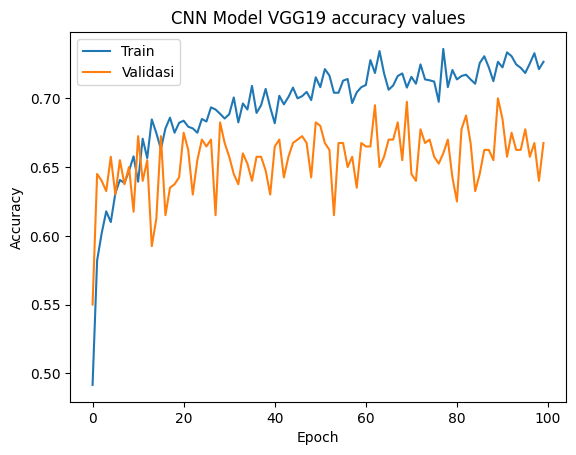

In [47]:
# Plot Akurasi
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('CNN Model VGG19 accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validasi'], loc='upper left')
plt.show()


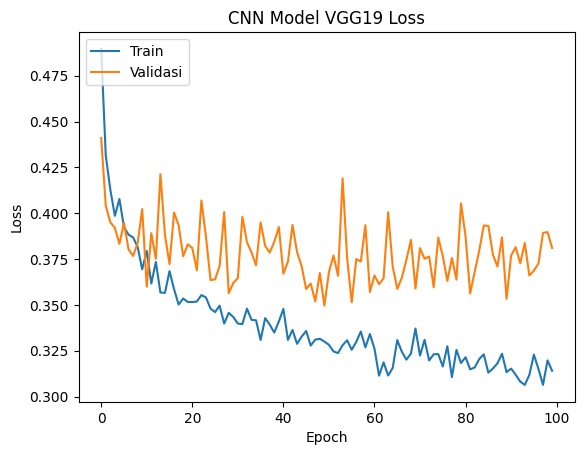

In [48]:
# Plot Loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('CNN Model VGG19 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validasi'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 125ms/step


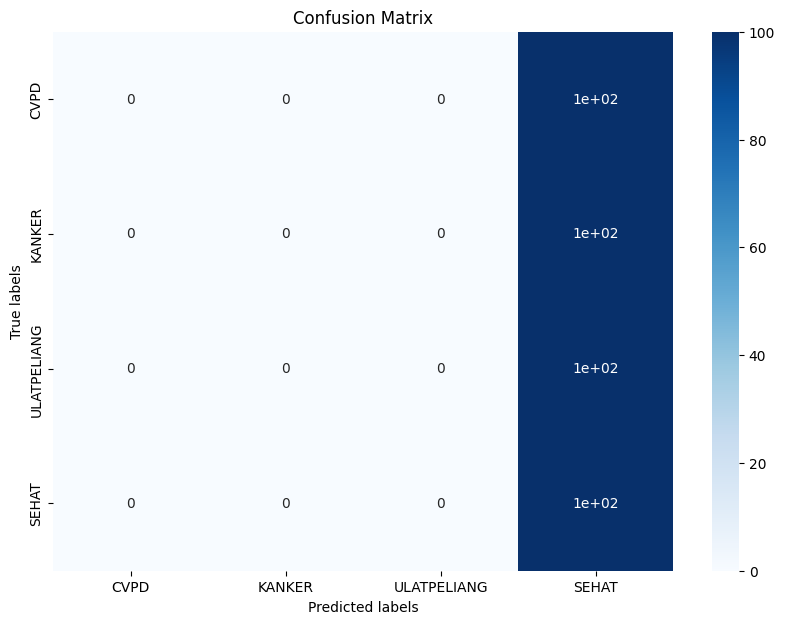

In [49]:
import os
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained model
model_path = "C:/Users/akip/Desktop/fix-vgg16/VGG19Epoch100.h4"
model = load_model(model_path)

# Define the path to your test image folder
test_path = "C:/Users/akip/Desktop/fix-vgg16/dataset/test"

# Define the class list
class_list = ['CVPD', 'KANKER', 'ULATPELIANG', 'SEHAT']

# Initialize lists to store true labels and predictions
y_true = []
y_pred = []

# Loop through all image files in the test folder
for class_name in class_list:
    class_path = os.path.join(test_path, class_name)
    
    if not os.path.exists(class_path):
        print(f"Directory does not exist: {class_path}")
        continue
    
    for filename in os.listdir(class_path):
        try:
            # Construct the complete image path
            img_path = os.path.join(class_path, filename)

            # Load and preprocess the image
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = img_array / 255.0

            # Make prediction
            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction, axis=1)[0]

            # Append the true and predicted labels
            y_true.append(class_list.index(class_name))
            y_pred.append(predicted_class)
        except PermissionError:
            print(f"Error accessing file: {filename}")
            # Optionally, log the error or skip to the next image

# Now that you have all the predictions and true labels, we can calculate the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', xticklabels=class_list, yticklabels=class_list)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [50]:
from sklearn.metrics import classification_report

# Buat laporan klasifikasi
report = classification_report(y_true, y_pred, target_names=class_list)

print('Classification Report')
print(report)

Classification Report
              precision    recall  f1-score   support

        CVPD       0.00      0.00      0.00       100
      KANKER       0.00      0.00      0.00       100
 ULATPELIANG       0.00      0.00      0.00       100
       SEHAT       0.25      1.00      0.40       100

    accuracy                           0.25       400
   macro avg       0.06      0.25      0.10       400
weighted avg       0.06      0.25      0.10       400



C:\Users\akip\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\akip\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\akip\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
